In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
#Colab setting cell
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CV/HW2')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/CV/HW2')

Mounted at /content/drive


# Edge detection

## 1. read image

In [3]:
template_image = cv2.imread("template_image.png")
target_image = cv2.imread("target_image.png")

## 2. Detect edge

Gaussian blur is used because a Low Pass Filter is needed to detect edge better


In [4]:
def image2edge(image, threshold1=50, threshold2=150):
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  LPF_image = cv2.GaussianBlur(image, (5, 5), 0)
  edge_image = cv2.Canny(LPF_image, threshold1, threshold2)

  return edge_image


template_edge_image = image2edge(template_image)
target_edge_image = image2edge(target_image)

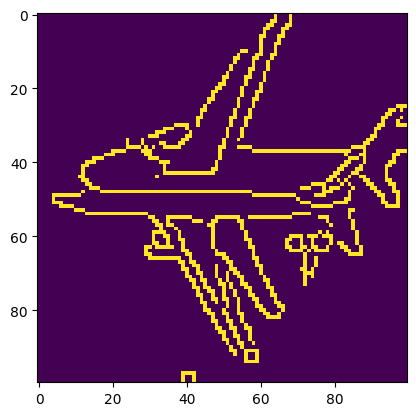

In [5]:
plt.imshow(template_edge_image)

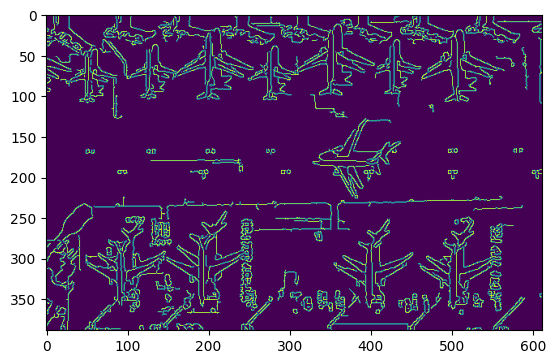

In [6]:
plt.imshow(target_edge_image)

# Generalized Hough Transform

## Calculate Gradients
- Sobel filter



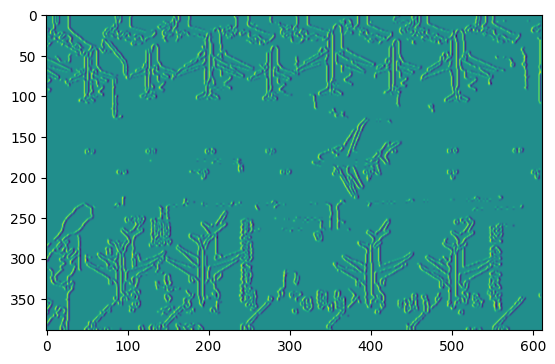

In [7]:
# Gradient orientation calculation using Sobel operators
def calculate_gradients(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    plt.imshow(sobelx)
    gradient = np.arctan2(sobely, sobelx)
    return gradient

template_gradients = calculate_gradients(template_edge_image)
#print(template_gradients[:3])
target_gradients = calculate_gradients(target_edge_image)


# Build R table and vote
scaling and rotation is also considered

### Functions for GHT

In [16]:
def calculate_r_table(image_edges, gradients, reference_point):
    # R-table dictionary to hold gradients and corresponding (r, alpha)
    r_table = {}
    for (i, j), value in np.ndenumerate(image_edges):
        if value:  # if edge is present
            phi = gradients[i, j]
            r = np.sqrt((reference_point[0] - i) ** 2
                        + (reference_point[1] - j) ** 2)
            alpha = np.arctan2(reference_point[1] - j, reference_point[0] - i)
            if phi not in r_table:
                r_table[phi] = []
            r_table[phi].append((r, alpha))
    return r_table

def generalized_hough_transform(target_edges,
                                gradients,
                                r_table,
                                scale_r = 1,
                                scale_alpha = 0):

    vote_num = np.zeros(target_edges.shape, dtype=np.uint32)
    for (i, j), value in np.ndenumerate(target_edges):
        if value:  # if edge is present
            phi = gradients[i, j]
            if phi in r_table:
                for r, alpha in r_table[phi]:
                    r = r * scale_r
                    alpha += scale_alpha
                    x = int(i + r * np.cos(alpha))
                    y = int(j + r * np.sin(alpha))
                    if ((0 <= x < vote_num.shape[0])
                        and (0 <= y < vote_num.shape[1])):
                        vote_num[x, y] += 1
    return vote_num

In [ ]:
def bigger_than_Threshold(image, threshold: int):
  results = []
  for (i, j), value in np.ndenumerate(image):
    if value >= threshold:
      results.append((i, j))
  return results

### Voting GHT
it only counts vote bigger than threshold

Change the parameters for the picture

In [17]:
# Parameters

scale_r_list = np.linspace(0.5, 1.5, 10)
scale_alpha_list = [0, np.pi/2, -np.pi/2]
# ========================================== #

reference_point = (template_edge_image.shape[0] // 2,
                   template_edge_image.shape[1] // 2)
r_table = calculate_r_table(template_edge_image,
                            template_gradients,
                            reference_point)

total_votes = []
for scale_r in scale_r_list:
  for scale_alpha in scale_alpha_list:
    vote_num = generalized_hough_transform(target_edge_image,
                                           target_gradients,
                                           r_table,
                                           scale_r=scale_r,
                                           scale_alpha=scale_alpha)
    total_votes.append(vote_num)

In [18]:
vote_threshold = 46

combined_votes = np.zeros_like(vote_num)
for vote in total_votes:
    combined_votes[vote >= vote_threshold] += vote[vote >= vote_threshold]

## Visualization

### The biggest vote

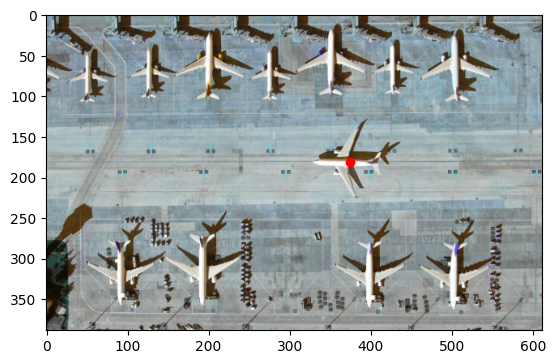

In [19]:
# Find the max in the accumulator space which gives us the best match
y, x = np.unravel_index(np.argmax(combined_votes), combined_votes.shape)


detected_position = (x, y)

# Visualize the result
plt.imshow(target_image, cmap='gray')
plt.autoscale(False)

plt.plot(x, y, 'ro')  # Detected position

plt.show()

### Votes bigger than threshold

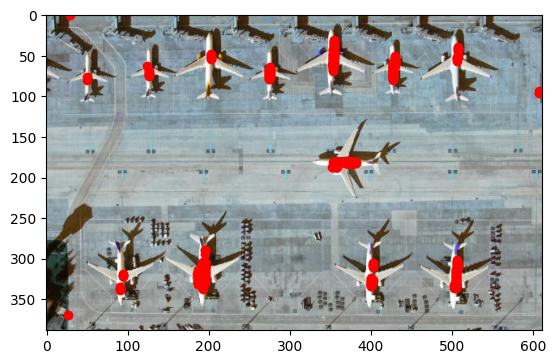

In [20]:
plt.imshow(target_image, cmap='gray')
plt.autoscale(False)
for (y, x), value in np.ndenumerate(combined_votes):
  if value:
    plt.plot(x, y, 'ro')  # Detected position

plt.show()

### Plot entire accumulator (including votes that are less than threshold)
The original vote_threshold is 46.

Here, it plots the accumulator bigger than 5. (To reduce noise)

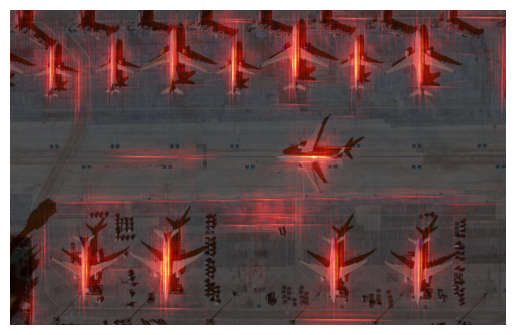

In [21]:
vote_threshold = 5

combined_votes = np.zeros_like(vote_num)
for vote in total_votes:
    combined_votes[vote >= vote_threshold] += vote[vote >= vote_threshold]

fig, ax = plt.subplots()

# Plot the target image
ax.imshow(target_image, cmap='gray')
ax.imshow(combined_votes, cmap = 'hot', alpha = 0.6)
# Hide axes
ax.axis('off')

plt.show()